In this example, we will compare development of a pairs trading strategy using backtrader and vectorbt.

In [1]:
# !pip install pandas_datareader
# !pip install vectorbt

In [2]:
# !pip install alpaca
# !pip install alpaca-py
# !pip install mplfinance
# !pip install pandas_ta
# !pip install --upgrade -U kaleido==0.2.1
# !pip install install matplotlib==3.2.1
# !pip install ipympl


In [3]:
# !pip show kaleido
# !pip show matplotlib

In [1]:
!pip install --upgrade plotly==6.1.1
!pip install --upgrade kaleido==1.0.0
!pip install anywidget

In [2]:
import numpy as np
import pandas as pd
import datetime
import collections
import math
import pytz

import datetime
# from datetime import datetime


In [3]:
import sys

print(sys.executable)
print(sys.version)
print(sys.version_info)

sys.path.append("C:\\Users\\steve\\git\\pylib") # go to parent dir
# sys.path.insert(0, 'utils/')

C:\Users\steve\miniconda3\envs\vectorbt\python.exe
3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=13, micro=5, releaselevel='final', serial=0)


In [4]:
from watchlist import colors, Watchlist # Is this failing? If so, copy it locally. See above.

from utils import *
from myInds import *


In [5]:
import scipy.stats as st

SYMBOL1 = 'tsla'
SYMBOL2 = 'coin'
delta = 60
TODATE = datetime.now()
FROMDATE = TODATE - timedelta(days=delta)

PERIOD = 100
CASH = 100000
COMMPERC = 0.005  # 0.5%
ORDER_PCT1 = 0.1
ORDER_PCT2 = 0.1
UPPER = st.norm.ppf(1 - 0.05 / 2)
LOWER = -st.norm.ppf(1 - 0.05 / 2)
MODE = 'OLS'  # OLS, log_return

In [6]:
print(sys.path)

['C:\\Users\\steve\\miniconda3\\envs\\vectorbt\\python313.zip', 'C:\\Users\\steve\\miniconda3\\envs\\vectorbt\\DLLs', 'C:\\Users\\steve\\miniconda3\\envs\\vectorbt\\Lib', 'C:\\Users\\steve\\miniconda3\\envs\\vectorbt', '', 'C:\\Users\\steve\\miniconda3\\envs\\vectorbt\\Lib\\site-packages', 'C:\\Users\\steve\\miniconda3\\envs\\vectorbt\\Lib\\site-packages\\win32', 'C:\\Users\\steve\\miniconda3\\envs\\vectorbt\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\steve\\miniconda3\\envs\\vectorbt\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\steve\\git\\pylib', 'C:\\Users\\steve\\miniconda3\\envs\\vectorbt\\Lib\\site-packages\\setuptools\\_vendor', '.', 'C:\\Users\\steve\\git\\TradingAgents', 'C:\\Users\\steve\\git\\pylib']


## Data

In [7]:
import vectorbt as vbt
import json

symbols = ['META', 'AAPL']
SYMBOL1 = symbols[0]
SYMBOL2 = symbols[1]

start_date = datetime(2020, 1, 1, tzinfo=pytz.utc)
end_date = datetime(2024, 1, 1, tzinfo=pytz.utc)
num_tests = 2000
tf = '1D'

data = retrieve_data(symbols, tf=tf)

# data = vbt.YFData.download([SYMBOL1, SYMBOL2], start=start_date, end=end_date)
data1 = data.data[SYMBOL1]
data2 = data.data[SYMBOL2]
raw_frames = {
    SYMBOL1: data1,
    SYMBOL2:  data2
    # "TSLA": tsla_df,  # add more as you like
}

# build the summary frame: index = ticker, column = "data"
# data = pd.DataFrame({
#     "data": pd.Series(raw_frames)            # keys become the index, values the column entries
# }).T                          # .T puts tickers on the rows
data = pd.DataFrame({
    "data": pd.Series(raw_frames)            # keys become the index, values the column entries
})

data.index.name = "ticker" # nice to name the index
    

[!] Loading All: META, AAPL
[i] Loaded META[1D]: META_1D.csv
[i] Runtime: 903.8844 ms (0.9039 s)
[i] Loaded AAPL[1D]: AAPL_1D.csv
[i] Runtime: 1186.6737 ms (1.1867 s)


## backtrader

Adapted version of https://github.com/mementum/backtrader/blob/master/contrib/samples/pair-trading/pair-trading.py

In [8]:
# !pip install backtrader
# !pip install statsmodels

In [9]:
import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.indicators as btind

class CommInfoFloat(bt.CommInfoBase):
    """Commission schema that keeps size as float."""
    params = (
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_PERC),
        ('percabs', True),
      )
    
    def getsize(self, price, cash):
        if not self._stocklike:
            return self.p.leverage * (cash / self.get_margin(price))

        return self.p.leverage * (cash / price)
    
class OLSSlopeIntercept(btind.PeriodN):
    """Calculates a linear regression using OLS."""
    _mindatas = 2  # ensure at least 2 data feeds are passed

    packages = (
        ('pandas', 'pd'),
        ('statsmodels.api', 'sm'),
    )
    lines = ('slope', 'intercept',)
    params = (
        ('period', 10),
    )

    def next(self):
        p0 = pd.Series(self.data0.get(size=self.p.period))
        p1 = pd.Series(self.data1.get(size=self.p.period))
        p1 = sm.add_constant(p1)
        intercept, slope = sm.OLS(p0, p1).fit().params

        self.lines.slope[0] = slope
        self.lines.intercept[0] = intercept
        
        
class Log(btind.Indicator):
    """Calculates log."""
    lines = ('log',)
    
    def next(self):
        self.l.log[0] = math.log(self.data[0])


class OLSSpread(btind.PeriodN):
    """Calculates the z-score of the OLS spread."""
    _mindatas = 2  # ensure at least 2 data feeds are passed
    lines = ('spread', 'spread_mean', 'spread_std', 'zscore',)
    params = (('period', 10),)

    def __init__(self):
        data0_log = Log(self.data0)
        data1_log = Log(self.data1)
        slint = OLSSlopeIntercept(data0_log, data1_log, period=self.p.period)

        spread = data0_log - (slint.slope * data1_log + slint.intercept)
        self.l.spread = spread

        self.l.spread_mean = bt.ind.SMA(spread, period=self.p.period)
        self.l.spread_std = bt.ind.StdDev(spread, period=self.p.period)
        self.l.zscore = (spread - self.l.spread_mean) / self.l.spread_std
    
class LogReturns(btind.PeriodN):
    """Calculates the log returns."""
    lines = ('logret',)
    params = (('period', 1),)
    
    def __init__(self):
        self.addminperiod(self.p.period + 1)
    
    def next(self):
        self.l.logret[0] = math.log(self.data[0] / self.data[-self.p.period])
    
class LogReturnSpread(btind.PeriodN):
    """Calculates the spread of the log returns."""
    _mindatas = 2  # ensure at least 2 data feeds are passed
    lines = ('logret0', 'logret1', 'spread', 'spread_mean', 'spread_std', 'zscore',)
    params = (('period', 10),)

    def __init__(self):
        self.l.logret0 = LogReturns(self.data0, period=1)
        self.l.logret1 = LogReturns(self.data1, period=1)
        self.l.spread = self.l.logret0 - self.l.logret1
        self.l.spread_mean = bt.ind.SMA(self.l.spread, period=self.p.period)
        self.l.spread_std = bt.ind.StdDev(self.l.spread, period=self.p.period)
        self.l.zscore = (self.l.spread - self.l.spread_mean) / self.l.spread_std

class PairTradingStrategy(bt.Strategy):
    """Basic pair trading strategy."""
    params = dict(
        period=PERIOD,
        order_pct1=ORDER_PCT1,
        order_pct2=ORDER_PCT2,
        printout=True,
        upper=UPPER,
        lower=LOWER,
        mode=MODE
    )

    def log(self, txt, dt=None):
        if self.p.printout:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE {}, size = {:.2f}, price = {:.2f}'.format(
                    order.data._name, order.executed.size, order.executed.price)
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = 'SELL COMPLETE {}, size = {:.2f}, price = {:.2f}'.format(
                    order.data._name, order.executed.size, order.executed.price)
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('%s ,' % order.Status[order.status])
            pass  # Simply log

        # Allow new orders
        self.orderid = None

    def __init__(self):
        # To control operation entries
        self.orderid = None
        self.order_pct1 = self.p.order_pct1
        self.order_pct2 = self.p.order_pct2
        self.upper = self.p.upper
        self.lower = self.p.lower
        self.status = 0
        
        # Signals performed with PD.OLS :
        if self.p.mode == 'log_return':
            self.transform = LogReturnSpread(self.data0, self.data1, period=self.p.period)
        elif self.p.mode == 'OLS':
            self.transform = OLSSpread(self.data0, self.data1, period=self.p.period)
        else:
            raise ValueError("Unknown mode")
        self.spread = self.transform.spread
        self.zscore = self.transform.zscore
        
        # For tracking
        self.spread_sr = pd.Series(dtype=float, name='spread')
        self.zscore_sr = pd.Series(dtype=float, name='zscore')
        self.short_signal_sr = pd.Series(dtype=bool, name='short_signals')
        self.long_signal_sr = pd.Series(dtype=bool, name='long_signals')

    def next(self):
        if self.orderid:
            return  # if an order is active, no new orders are allowed
        
        self.spread_sr[self.data0.datetime.datetime()] = self.spread[0]
        self.zscore_sr[self.data0.datetime.datetime()] = self.zscore[0]
        self.short_signal_sr[self.data0.datetime.datetime()] = False
        self.long_signal_sr[self.data0.datetime.datetime()] = False

        if self.zscore[0] > self.upper and self.status != 1:
            # Check conditions for shorting the spread & place the order
            self.short_signal_sr[self.data0.datetime.datetime()] = True

            # Placing the order
            self.log('SELL CREATE {}, price = {:.2f}, target pct = {:.2%}'.format(
                self.data0._name, self.data0.close[0], -self.order_pct1))
            self.order_target_percent(data=self.data0, target=-self.order_pct1)
            self.log('BUY CREATE {}, price = {:.2f}, target pct = {:.2%}'.format(
                self.data1._name, self.data1.close[0], self.order_pct2))
            self.order_target_percent(data=self.data1, target=self.order_pct2)

            self.status = 1

        elif self.zscore[0] < self.lower and self.status != 2:
            # Check conditions for longing the spread & place the order
            self.long_signal_sr[self.data0.datetime.datetime()] = True

            # Place the order
            self.log('SELL CREATE {}, price = {:.2f}, target pct = {:.2%}'.format(
                self.data1._name, self.data1.close[0], -self.order_pct2))
            self.order_target_percent(data=self.data1, target=-self.order_pct2)
            self.log('BUY CREATE {}, price = {:.2f}, target pct = {:.2%}'.format(
                self.data0._name, self.data0.close[0], self.order_pct1))
            self.order_target_percent(data=self.data0, target=self.order_pct1)
                     
            self.status = 2

    def stop(self):
        if self.p.printout:
            print('==================================================')
            print('Starting Value - %.2f' % self.broker.startingcash)
            print('Ending   Value - %.2f' % self.broker.getvalue())
            print('==================================================')

In [10]:
class DataAnalyzer(bt.analyzers.Analyzer):
    """Analyzer to extract OHLCV."""
    def create_analysis(self):
        self.rets0 = {}
        self.rets1 = {}

    def next(self):
        self.rets0[self.strategy.datetime.datetime()] = [
            self.data0.open[0],
            self.data0.high[0],
            self.data0.low[0],
            self.data0.close[0],
            self.data0.volume[0]
        ]
        self.rets1[self.strategy.datetime.datetime()] = [
            self.data1.open[0],
            self.data1.high[0],
            self.data1.low[0],
            self.data1.close[0],
            self.data1.volume[0]
        ]

    def get_analysis(self):
        return self.rets0, self.rets1

class CashValueAnalyzer(bt.analyzers.Analyzer):
    """Analyzer to extract cash and value."""
    def create_analysis(self):
        self.rets = {}

    def notify_cashvalue(self, cash, value):
        self.rets[self.strategy.datetime.datetime()] = (cash, value)

    def get_analysis(self):
        return self.rets
    
class OrderAnalyzer(bt.analyzers.Analyzer):
    """Analyzer to extract order price, size, value, and paid commission."""
    def create_analysis(self):
        self.rets0 = {}
        self.rets1 = {}

    def notify_order(self, order):
        if order.status == order.Completed:
            if order.data._name == SYMBOL1:
                rets = self.rets0
            else:
                rets = self.rets1
            rets[self.strategy.datetime.datetime()] = (
                order.executed.price,
                order.executed.size,
                -order.executed.size * order.executed.price,
                order.executed.comm
            )

    def get_analysis(self):
        return self.rets0, self.rets1

In [11]:
def prepare_cerebro(data0, data1, use_analyzers=True, **params):
    # Create a cerebro
    cerebro = bt.Cerebro()

    # Add the 1st data to cerebro
    cerebro.adddata(data0)

    # Add the 2nd data to cerebro
    cerebro.adddata(data1)

    # Add the strategy
    cerebro.addstrategy(PairTradingStrategy, **params)

    # Add the commission - only stocks like a for each operation
    cerebro.broker.setcash(CASH)

    # Add the commission - only stocks like a for each operation
    comminfo = CommInfoFloat(commission=COMMPERC)
    cerebro.broker.addcommissioninfo(comminfo)

    if use_analyzers:
        # Add analyzers    
        cerebro.addanalyzer(DataAnalyzer)
        cerebro.addanalyzer(CashValueAnalyzer)
        cerebro.addanalyzer(OrderAnalyzer)
    
    return cerebro

In [12]:
class PandasData(btfeeds.PandasData):
    params = (
        # Possible values for datetime (must always be present)
        #  None : datetime is the "index" in the Pandas Dataframe
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('datetime', None),

        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', None),
    )

In [13]:
# Create the 1st data
data0 = PandasData(dataname=data.data[SYMBOL1], name=SYMBOL1)
print(data.data[SYMBOL1])
# Create the 2nd data
data1 = PandasData(dataname=data.data[SYMBOL2], name=SYMBOL2)

# Prepare a cerebro
cerebro = prepare_cerebro(data0, data1)

# And run it
bt_strategy = cerebro.run()[0]

                            close      high  ...  PPOs_12_26_9  CUMLOGRET_1
Datetime                                     ...                           
2020-08-05 04:00:00+00:00  249.12  252.2698  ...           NaN     0.000000
2020-08-06 04:00:00+00:00  265.28  266.6000  ...           NaN     0.062851
2020-08-07 04:00:00+00:00  268.44  278.8900  ...           NaN     0.074693
2020-08-10 04:00:00+00:00  263.00  273.8600  ...           NaN     0.054219
2020-08-11 04:00:00+00:00  256.13  265.9150  ...           NaN     0.027750
...                           ...       ...  ...           ...          ...
2025-07-28 04:00:00+00:00  717.63  724.7352  ...      0.386454     1.058019
2025-07-29 04:00:00+00:00  700.00  724.4700  ...      0.148106     1.033146
2025-07-30 04:00:00+00:00  695.21  708.5000  ...     -0.098934     1.026279
2025-07-31 04:00:00+00:00  773.44  784.7500  ...     -0.215071     1.132913
2025-08-01 04:00:00+00:00  750.01  765.9999  ...     -0.242743     1.102152

[1254 rows 

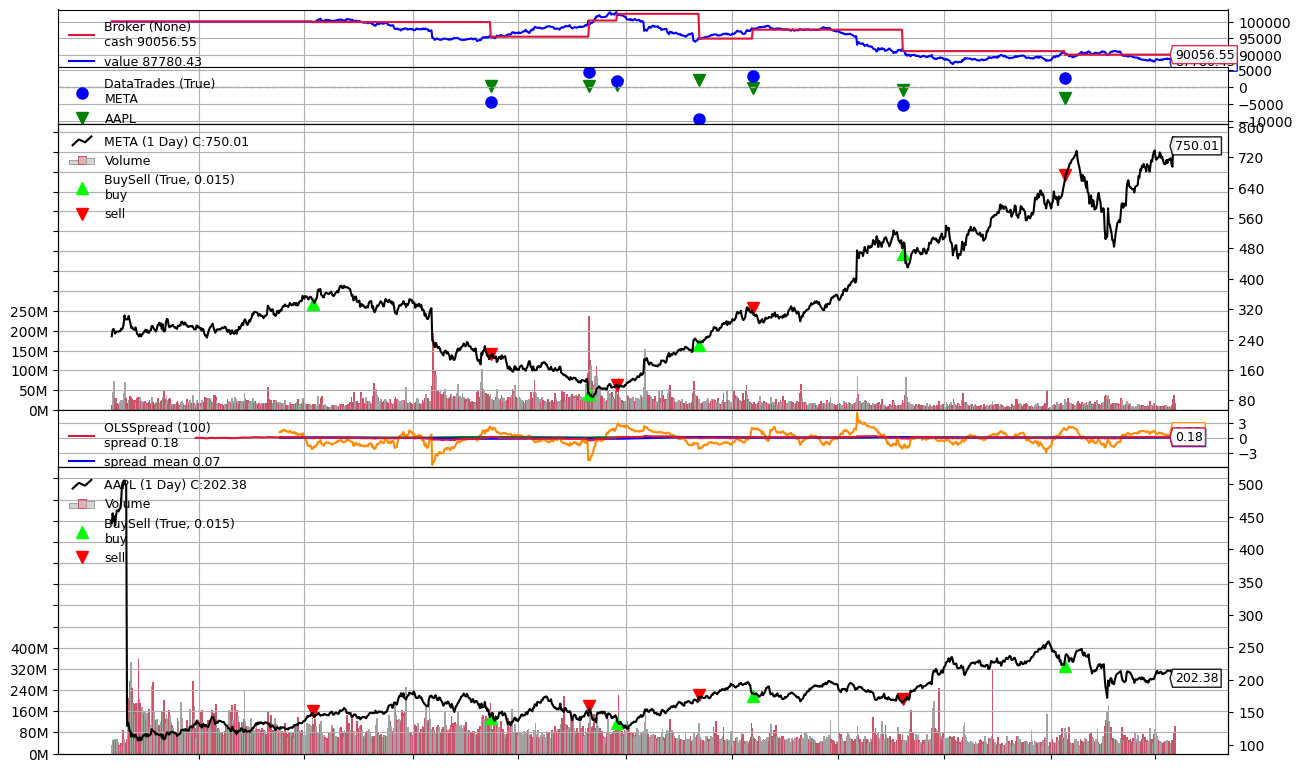

[[<Figure size 1300x800 with 7 Axes>]]

In [15]:
%matplotlib inline
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (13, 8)
cerebro.plot(iplot=False)

In [16]:
# Extract OHLCV
bt_s1_rets, bt_s2_rets = bt_strategy.analyzers.dataanalyzer.get_analysis()
data_cols = ['open', 'high', 'low', 'close', 'volume']
bt_s1_ohlcv = pd.DataFrame.from_dict(bt_s1_rets, orient='index', columns=data_cols)
bt_s2_ohlcv = pd.DataFrame.from_dict(bt_s2_rets, orient='index', columns=data_cols)

print(bt_s1_ohlcv.shape)
print(bt_s2_ohlcv.shape)

print(bt_s1_ohlcv.iloc[[0, -1]])
print(bt_s2_ohlcv.iloc[[0, -1]])

(1254, 5)
(1254, 5)
                       open      high     low   close      volume
2020-08-05 04:00:00  250.19  252.2698  247.77  249.12  14019505.0
2025-08-01 04:00:00  760.73  765.9999  745.31  750.01  19028710.0
                        open    high     low   close       volume
2020-08-05 04:00:00  437.510  441.57  435.59  440.25   32190632.0
2025-08-01 04:00:00  210.865  213.58  201.50  202.38  104434473.0


In [17]:
try:
    np.testing.assert_allclose(bt_s1_ohlcv.values, data.data[SYMBOL1].iloc[:, :5].values)
    np.testing.assert_allclose(bt_s2_ohlcv.values, data.data[SYMBOL2].iloc[:, :5].values)
except AssertionError as e:
    print(e)


Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 3762 / 6270 (60%)
Max absolute difference among violations: 2.35792122e+08
Max relative difference among violations: 215.98038892
 ACTUAL: array([[2.501900e+02, 2.522698e+02, 2.477700e+02, 2.491200e+02,
        1.401950e+07],
       [2.490400e+02, 2.666000e+02, 2.486650e+02, 2.652800e+02,...
 DESIRED: array([[2.491200e+02, 2.522698e+02, 2.477700e+02, 2.501900e+02,
        1.434800e+05],
       [2.652800e+02, 2.666000e+02, 2.486650e+02, 2.490400e+02,...


In [18]:
# Extract cash and value series
bt_cashvalue_rets = bt_strategy.analyzers.cashvalueanalyzer.get_analysis()
bt_cashvalue_df = pd.DataFrame.from_dict(bt_cashvalue_rets, orient='index', columns=['cash', 'value'])
bt_cash = bt_cashvalue_df['cash']
bt_value = bt_cashvalue_df['value']

print(bt_cash.iloc[[0, -1]])
print(bt_value.iloc[[0, -1]])

2020-08-05 04:00:00    100000.000000
2025-08-01 04:00:00     90056.552822
Name: cash, dtype: float64
2020-08-05 04:00:00    100000.000000
2025-08-01 04:00:00     87780.427036
Name: value, dtype: float64


In [19]:
# Extract order info
bt_s1_order_rets, bt_s2_order_rets = bt_strategy.analyzers.orderanalyzer.get_analysis()
order_cols = ['order_price', 'order_size', 'order_value', 'order_comm']
bt_s1_orders = pd.DataFrame.from_dict(bt_s1_order_rets, orient='index', columns=order_cols)
bt_s2_orders = pd.DataFrame.from_dict(bt_s2_order_rets, orient='index', columns=order_cols)

print(bt_s1_orders.iloc[[0, -1]])
print(bt_s2_orders.iloc[[0, -1]])

                     order_price  order_size   order_value  order_comm
2021-07-15 04:00:00     349.2348   28.766217 -10046.164025   50.230820
2025-01-27 05:00:00     626.6100  -33.129967  20759.568466  103.797842
                     order_price  order_size   order_value  order_comm
2021-07-15 04:00:00       149.24  -67.046597  10006.034194   50.030171
2025-01-27 05:00:00       224.02   96.463996 -21609.864316  108.049322


In [20]:
# Extract spread and z-score
bt_spread = bt_strategy.spread_sr
bt_zscore = bt_strategy.zscore_sr

print(bt_spread.iloc[[0, -1]])
print(bt_zscore.iloc[[0, -1]])

2021-05-19 04:00:00    0.108782
2025-08-01 04:00:00    0.179419
Name: spread, dtype: float64
2021-05-19 04:00:00    1.151764
2025-08-01 04:00:00    1.231189
Name: zscore, dtype: float64


In [21]:
# Extract signals
bt_short_signals = bt_strategy.short_signal_sr
bt_long_signals = bt_strategy.long_signal_sr

print(bt_short_signals[bt_short_signals])
print(bt_long_signals[bt_long_signals])

2022-05-12 04:00:00    True
2022-12-14 05:00:00    True
2023-08-07 04:00:00    True
2025-01-24 05:00:00    True
Name: short_signals, dtype: bool
2021-07-14 04:00:00    True
2022-10-27 04:00:00    True
2023-05-05 04:00:00    True
2024-04-19 04:00:00    True
Name: long_signals, dtype: bool


In [22]:
# How fast is bt?
cerebro = prepare_cerebro(data0, data1, use_analyzers=False, printout=False)

%timeit cerebro.run(preload=False)

3.9 s ± 596 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## vectorbt

### Using Portfolio.from_orders

In [23]:
from numba import njit

@njit
def rolling_logret_zscore_nb(a, b, period):
    """Calculate the log return spread."""
    spread = np.full_like(a, np.nan, dtype=np.float64)
    spread[1:] = np.log(a[1:] / a[:-1]) - np.log(b[1:] / b[:-1])
    zscore = np.full_like(a, np.nan, dtype=np.float64)
    for i in range(a.shape[0]):
        from_i = max(0, i + 1 - period)
        to_i = i + 1
        if i < period - 1:
            continue
        spread_mean = np.mean(spread[from_i:to_i])
        spread_std = np.std(spread[from_i:to_i])
        zscore[i] = (spread[i] - spread_mean) / spread_std
    return spread, zscore

@njit
def ols_spread_nb(a, b):
    """Calculate the OLS spread."""
    a = np.log(a)
    b = np.log(b)
    _b = np.vstack((b, np.ones(len(b)))).T
    slope, intercept = np.dot(np.linalg.inv(np.dot(_b.T, _b)), np.dot(_b.T, a))
    spread = a - (slope * b + intercept)
    return spread[-1]
    
@njit
def rolling_ols_zscore_nb(a, b, period):
    """Calculate the z-score of the rolling OLS spread."""
    spread = np.full_like(a, np.nan, dtype=np.float64)
    zscore = np.full_like(a, np.nan, dtype=np.float64)
    for i in range(a.shape[0]):
        from_i = max(0, i + 1 - period)
        to_i = i + 1
        if i < period - 1:
            continue
        spread[i] = ols_spread_nb(a[from_i:to_i], b[from_i:to_i])
        spread_mean = np.mean(spread[from_i:to_i])
        spread_std = np.std(spread[from_i:to_i])
        zscore[i] = (spread[i] - spread_mean) / spread_std
    return spread, zscore

In [24]:
# Calculate OLS z-score using Numba for a nice speedup
if MODE == 'OLS':
    vbt_spread, vbt_zscore = rolling_ols_zscore_nb(
        bt_s1_ohlcv['close'].values, 
        bt_s2_ohlcv['close'].values, 
        PERIOD
    )
elif MODE == 'log_return':
    vbt_spread, vbt_zscore = rolling_logret_zscore_nb(
        bt_s1_ohlcv['close'].values, 
        bt_s2_ohlcv['close'].values, 
        PERIOD
    )
else:
    raise ValueError("Unknown mode")
vbt_spread = pd.Series(vbt_spread, index=bt_s1_ohlcv.index, name='spread')
vbt_zscore = pd.Series(vbt_zscore, index=bt_s1_ohlcv.index, name='zscore')

In [25]:
# Assert equality of bt and vbt z-score arrays
pd.testing.assert_series_equal(bt_spread, vbt_spread[bt_spread.index])
pd.testing.assert_series_equal(bt_zscore, vbt_zscore[bt_zscore.index])

In [26]:
# Generate short and long spread signals
vbt_short_signals = (vbt_zscore > UPPER).rename('short_signals')
vbt_long_signals = (vbt_zscore < LOWER).rename('long_signals')

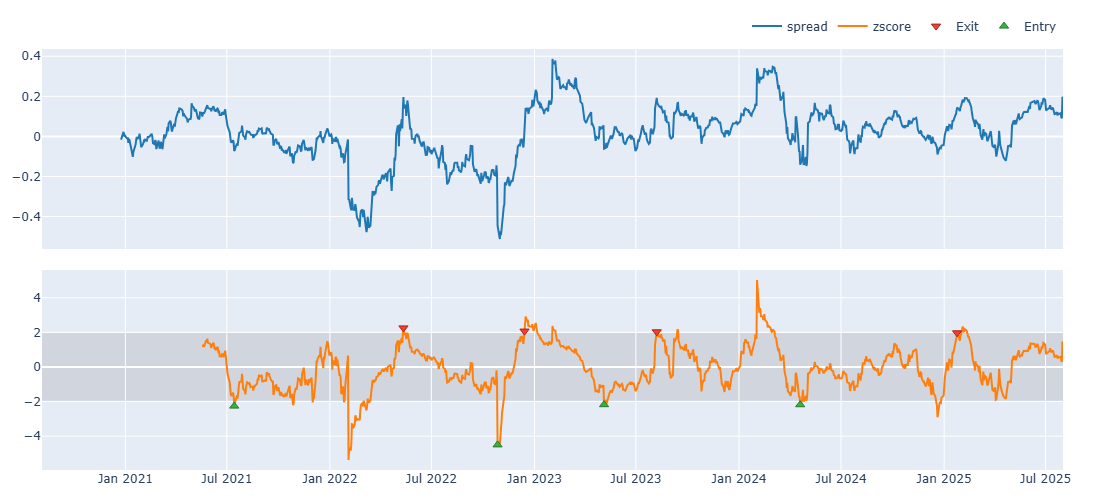

In [27]:
vbt_short_signals, vbt_long_signals = pd.Series.vbt.signals.clean(
    vbt_short_signals, vbt_long_signals, entry_first=False, broadcast_kwargs=dict(columns_from='keep'))

def plot_spread_and_zscore(spread, zscore):
    fig = vbt.make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)
    spread.vbt.plot(add_trace_kwargs=dict(row=1, col=1), fig=fig)
    zscore.vbt.plot(add_trace_kwargs=dict(row=2, col=1), fig=fig)
    vbt_short_signals.vbt.signals.plot_as_exit_markers(zscore, add_trace_kwargs=dict(row=2, col=1), fig=fig)
    vbt_long_signals.vbt.signals.plot_as_entry_markers(zscore, add_trace_kwargs=dict(row=2, col=1), fig=fig)
    fig.update_layout(height=500)
    fig.add_shape(
        type="rect",
        xref='paper',
        yref='y2',
        x0=0,
        y0=UPPER,
        x1=1,
        y1=LOWER,
        fillcolor="gray",
        opacity=0.2,
        layer="below",
        line_width=0,
    )
    return fig
    
plot_spread_and_zscore(vbt_spread, vbt_zscore).show()

In [28]:
# Assert equality of bt and vbt signal arrays
pd.testing.assert_series_equal(
    bt_short_signals[bt_short_signals], 
    vbt_short_signals[vbt_short_signals]
)
pd.testing.assert_series_equal(
    bt_long_signals[bt_long_signals], 
    vbt_long_signals[vbt_long_signals]
)

In [29]:
# Build percentage order size
symbol_cols = pd.Index([SYMBOL1, SYMBOL2], name='symbol')
vbt_order_size = pd.DataFrame(index=bt_s1_ohlcv.index, columns=symbol_cols)
vbt_order_size[SYMBOL1] = np.nan
vbt_order_size[SYMBOL2] = np.nan
vbt_order_size.loc[vbt_short_signals, SYMBOL1] = -ORDER_PCT1
vbt_order_size.loc[vbt_long_signals, SYMBOL1] = ORDER_PCT1
vbt_order_size.loc[vbt_short_signals, SYMBOL2] = ORDER_PCT2
vbt_order_size.loc[vbt_long_signals, SYMBOL2] = -ORDER_PCT2

# Execute at the next bar
vbt_order_size = vbt_order_size.vbt.fshift(1)

print(vbt_order_size[~vbt_order_size.isnull().any(axis=1)])

symbol               META  AAPL
2021-07-15 04:00:00   0.1  -0.1
2022-05-13 04:00:00  -0.1   0.1
2022-10-28 04:00:00   0.1  -0.1
2022-12-15 05:00:00  -0.1   0.1
2023-05-08 04:00:00   0.1  -0.1
2023-08-08 04:00:00  -0.1   0.1
2024-04-22 04:00:00   0.1  -0.1
2025-01-27 05:00:00  -0.1   0.1


In [30]:
# Simulate the portfolio
vbt_close_price = pd.concat((bt_s1_ohlcv['close'], bt_s2_ohlcv['close']), axis=1, keys=symbol_cols)
vbt_open_price = pd.concat((bt_s1_ohlcv['open'], bt_s2_ohlcv['open']), axis=1, keys=symbol_cols)

def simulate_from_orders():
    """Simulate using `Portfolio.from_orders`."""
    return vbt.Portfolio.from_orders(
        vbt_close_price,  # current close as reference price
        size=vbt_order_size,  
        price=vbt_open_price,  # current open as execution price
        size_type='targetpercent', 
        val_price=vbt_close_price.vbt.fshift(1),  # previous close as group valuation price
        init_cash=CASH,
        fees=COMMPERC,
        cash_sharing=True,  # share capital between assets in the same group
        group_by=True,  # all columns belong to the same group
        call_seq='auto',  # sell before buying
        freq='d'  # index frequency for annualization
    )

vbt_pf = simulate_from_orders()

In [31]:
print(vbt_pf.orders.records_readable)

    Order Id Column  ...        Fees  Side
0          0   AAPL  ...   50.030171  Sell
1          1   META  ...   50.230820   Buy
2          2   META  ...   75.935979  Sell
3          3   AAPL  ...   97.054783   Buy
4          4   AAPL  ...  101.117493  Sell
5          5   META  ...   75.925870   Buy
6          6   META  ...  110.632107  Sell
7          7   AAPL  ...   99.539662   Buy
8          8   AAPL  ...  109.194021  Sell
9          9   META  ...  145.154509   Buy
10        10   META  ...  112.902783  Sell
11        11   AAPL  ...   98.470317   Buy
12        12   AAPL  ...   91.352903  Sell
13        13   META  ...  122.495830   Buy
14        14   META  ...  103.797842  Sell
15        15   AAPL  ...  108.049322   Buy

[16 rows x 7 columns]


In [32]:
# Proof that both bt and vbt produce the same result
pd.testing.assert_series_equal(bt_cash, vbt_pf.cash().rename('cash'))
pd.testing.assert_series_equal(bt_value, vbt_pf.value().rename('value'))

In [33]:
print(vbt_pf.stats())

Start            2020-08-05 04:00:00
End              2025-08-01 04:00:00
Period            1254 days 00:00:00
Start Value                 100000.0
End Value               87780.427036
                        ...         
Expectancy               -679.226914
Sharpe Ratio               -0.763466
Calmar Ratio               -0.244629
Omega Ratio                 0.870838
Sortino Ratio              -0.934963
Name: group, Length: 28, dtype: object


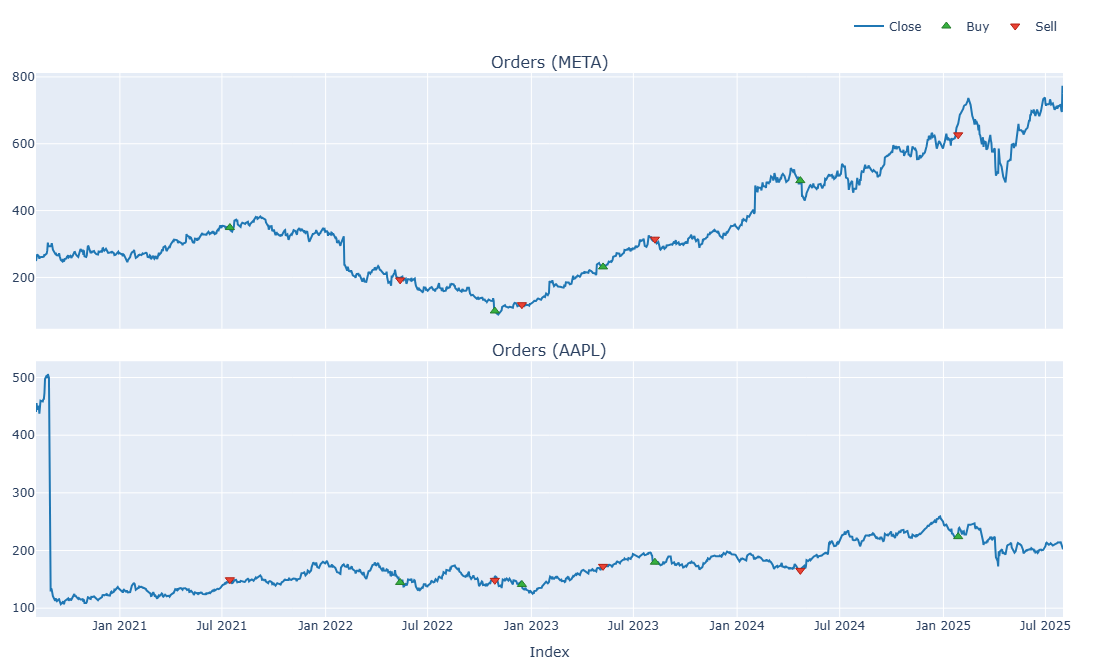

In [40]:
# Plot portfolio
from functools import partial

def plot_orders(fig, portfolio, column=None, add_trace_kwargs=None, **kwargs):
    portfolio.orders.plot(fig=fig,column=column, add_trace_kwargs=add_trace_kwargs)

vbt_pf.plot(subplots=[
    ('symbol1_orders', dict(
        title=f"Orders ({SYMBOL1})",
        yaxis_title="Price",
        check_is_not_grouped=False,
        plot_func=partial(plot_orders, column=SYMBOL1),
        pass_column=False
    )),
    ('symbol2_orders', dict(
        title=f"Orders ({SYMBOL2})",
        yaxis_title="Price",
        check_is_not_grouped=False,
        plot_func=partial(plot_orders, column=SYMBOL2),
        pass_column=False
    ))
]).show()

In [41]:
# How fast is vbt?
%timeit simulate_from_orders()

3.67 ms ± 259 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


While Portfolio.from_orders is a very convenient and optimized function for simulating portfolios, it requires some prior steps to produce the size array. In the example above, we needed to manually run the calculation of the spread z-score, generate the signals from the z-score, build the size array from the signals, and make sure that all arrays are perfectly aligned. All these steps must be repeated and adapted accordingly once there is more than one hyperparameter combination to test.

Nevertheless, dividing the pipeline into clearly separated backtesting steps helps us to analyze each step thoroughly and actually does wonders for strategy development and debugging.

### Using Portfolio.from_order_func

Portfolio.from_order_func follows a different (self-contained) approach where as much steps as possible should be defined in the simulation function itself. It sequentially processes timestamps one by one and executes orders based on the logic the user defined rather than parses this logic from some arrays. While this makes order execution less transparent as you cannot analyze each piece of data on the fly anymore (sadly, no pandas and plotting within Numba), it has one big advantage over other vectorized methods: event-driven order processing. This gives best flexibility (you can write any logic), security (less probability of exposing yourself to a look-ahead bias among other biases), and performance (you're traversing the data only once). This method is the most similar one compared to backtrader.

In [42]:
from vectorbt.portfolio import nb as portfolio_nb
from vectorbt.base.reshape_fns import flex_select_auto_nb
from vectorbt.portfolio.enums import SizeType, Direction
from collections import namedtuple

Memory = namedtuple("Memory", ('spread', 'zscore', 'status'))
Params = namedtuple("Params", ('period', 'upper', 'lower', 'order_pct1', 'order_pct2'))

@njit
def pre_group_func_nb(c, _period, _upper, _lower, _order_pct1, _order_pct2):
    """Prepare the current group (= pair of columns)."""
    assert c.group_len == 2
    
    # In contrast to bt, we don't have a class instance that we could use to store arrays,
    # so let's create a namedtuple acting as a container for our arrays
    # ( you could also pass each array as a standalone object, but a single object is more convenient)
    spread = np.full(c.target_shape[0], np.nan, dtype=np.float64)
    zscore = np.full(c.target_shape[0], np.nan, dtype=np.float64)
    
    # Note that namedtuples aren't mutable, you can't simply assign a value,
    # thus make status variable an array of one element for an easy assignment
    status = np.full(1, 0, dtype=np.int64)
    memory = Memory(spread, zscore, status)
    
    # Treat each param as an array with value per group, and select the combination of params for this group
    period = flex_select_auto_nb(np.asarray(_period), 0, c.group, True)
    upper = flex_select_auto_nb(np.asarray(_upper), 0, c.group, True)
    lower = flex_select_auto_nb(np.asarray(_lower), 0, c.group, True)
    order_pct1 = flex_select_auto_nb(np.asarray(_order_pct1), 0, c.group, True)
    order_pct2 = flex_select_auto_nb(np.asarray(_order_pct2), 0, c.group, True)
    
    # Put all params into a container (again, this is optional)
    params = Params(period, upper, lower, order_pct1, order_pct2)
    
    # Create an array that will store our two target percentages used by order_func_nb
    # we do it here instead of in pre_segment_func_nb to initialize the array once, instead of in each row
    size = np.empty(c.group_len, dtype=np.float64)
    
    # The returned tuple is passed as arguments to the function below
    return (memory, params, size)
    

@njit
def pre_segment_func_nb(c, memory, params, size, mode):
    """Prepare the current segment (= row within group)."""
    
    # We want to perform calculations once we reach full window size
    if c.i < params.period - 1:
        size[0] = np.nan  # size of nan means no order
        size[1] = np.nan
        return (size,)
    
    # z-core is calculated using a window (=period) of spread values
    # This window can be specified as a slice
    window_slice = slice(max(0, c.i + 1 - params.period), c.i + 1)
    
    # Here comes the same as in rolling_ols_zscore_nb
    if mode == 'OLS':
        a = c.close[window_slice, c.from_col]
        b = c.close[window_slice, c.from_col + 1]
        memory.spread[c.i] = ols_spread_nb(a, b)
    elif mode == 'log_return':
        logret_a = np.log(c.close[c.i, c.from_col] / c.close[c.i - 1, c.from_col])
        logret_b = np.log(c.close[c.i, c.from_col + 1] / c.close[c.i - 1, c.from_col + 1])
        memory.spread[c.i] = logret_a - logret_b
    else:
        raise ValueError("Unknown mode")
    spread_mean = np.mean(memory.spread[window_slice])
    spread_std = np.std(memory.spread[window_slice])
    memory.zscore[c.i] = (memory.spread[c.i] - spread_mean) / spread_std
    
    # Check if any bound is crossed
    # Since zscore is calculated using close, use zscore of the previous step
    # This way we are executing signals defined at the previous bar
    # Same logic as in PairTradingStrategy
    if memory.zscore[c.i - 1] > params.upper and memory.status[0] != 1:
        size[0] = -params.order_pct1
        size[1] = params.order_pct2
        
        # Here we specify the order of execution
        # call_seq_now defines order for the current group (2 elements)
        c.call_seq_now[0] = 0
        c.call_seq_now[1] = 1
        memory.status[0] = 1
    elif memory.zscore[c.i - 1] < params.lower and memory.status[0] != 2:
        size[0] = params.order_pct1
        size[1] = -params.order_pct2
        c.call_seq_now[0] = 1  # execute the second order first to release funds early
        c.call_seq_now[1] = 0
        memory.status[0] = 2
    else:
        size[0] = np.nan
        size[1] = np.nan
        
    # Group value is converted to shares using previous close, just like in bt
    # Note that last_val_price contains valuation price of all columns, not just the current pair
    c.last_val_price[c.from_col] = c.close[c.i - 1, c.from_col]
    c.last_val_price[c.from_col + 1] = c.close[c.i - 1, c.from_col + 1]
        
    return (size,)

@njit
def order_func_nb(c, size, price, commperc):
    """Place an order (= element within group and row)."""
    
    # Get column index within group (if group starts at column 58 and current column is 59, 
    # the column within group is 1, which can be used to get size)
    group_col = c.col - c.from_col
    return portfolio_nb.order_nb(
        size=size[group_col], 
        price=price[c.i, c.col],
        size_type=SizeType.TargetPercent,
        fees=commperc
    )

In [43]:
def simulate_from_order_func():
    """Simulate using `Portfolio.from_order_func`."""
    return vbt.Portfolio.from_order_func(
        vbt_close_price,
        order_func_nb, 
        vbt_open_price.values, COMMPERC,  # *args for order_func_nb
        pre_group_func_nb=pre_group_func_nb, 
        pre_group_args=(PERIOD, UPPER, LOWER, ORDER_PCT1, ORDER_PCT2),
        pre_segment_func_nb=pre_segment_func_nb, 
        pre_segment_args=(MODE,),
        fill_pos_record=False,  # a bit faster
        init_cash=CASH,
        cash_sharing=True, 
        group_by=True,
        freq='d'
    )

vbt_pf2 = simulate_from_order_func()

In [44]:
print(vbt_pf2.orders.records_readable)

    Order Id Column  ...        Fees  Side
0          0   AAPL  ...   50.030171  Sell
1          1   META  ...   50.230820   Buy
2          2   META  ...   75.935979  Sell
3          3   AAPL  ...   97.054783   Buy
4          4   AAPL  ...  101.117493  Sell
5          5   META  ...   75.925870   Buy
6          6   META  ...  110.632107  Sell
7          7   AAPL  ...   99.539662   Buy
8          8   AAPL  ...  109.194021  Sell
9          9   META  ...  145.154509   Buy
10        10   META  ...  112.902783  Sell
11        11   AAPL  ...   98.470317   Buy
12        12   AAPL  ...   91.352903  Sell
13        13   META  ...  122.495830   Buy
14        14   META  ...  103.797842  Sell
15        15   AAPL  ...  108.049322   Buy

[16 rows x 7 columns]


In [45]:
# Proof that both bt and vbt produce the same result
pd.testing.assert_series_equal(bt_cash, vbt_pf2.cash().rename('cash'))
pd.testing.assert_series_equal(bt_value, vbt_pf2.value().rename('value'))

In [46]:
# How fast is vbt?
%timeit simulate_from_order_func()

7.33 ms ± 812 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Numba paradise (or hell?) - fastest

In [47]:
def simulate_nb_from_order_func():
    """Simulate using `simulate_nb`."""
    # iterate over 502 rows and 2 columns, each element is a potential order
    target_shape = vbt_close_price.shape
    
    # number of columns in the group - exactly two
    group_lens = np.array([2])
    
    # build default call sequence (orders are executed from the left to the right column)
    call_seq = portfolio_nb.build_call_seq(target_shape, group_lens)
    
    # initial cash per group
    init_cash = np.array([CASH], dtype=np.float64)
    
    order_records, log_records = portfolio_nb.simulate_nb(
        target_shape=target_shape, 
        group_lens=group_lens,
        init_cash=init_cash,
        cash_sharing=True,
        call_seq=call_seq,  
        segment_mask=np.full(target_shape, True),  # used for disabling some segments
        pre_group_func_nb=pre_group_func_nb, 
        pre_group_args=(PERIOD, UPPER, LOWER, ORDER_PCT1, ORDER_PCT2),
        pre_segment_func_nb=pre_segment_func_nb, 
        pre_segment_args=(MODE,),
        order_func_nb=order_func_nb, 
        order_args=(vbt_open_price.values, COMMPERC),
        close=vbt_close_price.values,  # used for target percentage, but we override the valuation price
        fill_pos_record=False
    )
    
    return target_shape, group_lens, call_seq, init_cash, order_records, log_records

target_shape, group_lens, call_seq, init_cash, order_records, log_records = simulate_nb_from_order_func()

In [48]:
# Print order records in a readable format
print(vbt.Orders(vbt_close_price.vbt.wrapper, order_records, vbt_close_price).records_readable)

    Order Id Column  ...        Fees  Side
0          0   AAPL  ...   50.030171  Sell
1          1   META  ...   50.230820   Buy
2          2   META  ...   75.935979  Sell
3          3   AAPL  ...   97.054783   Buy
4          4   AAPL  ...  101.117493  Sell
5          5   META  ...   75.925870   Buy
6          6   META  ...  110.632107  Sell
7          7   AAPL  ...   99.539662   Buy
8          8   AAPL  ...  109.194021  Sell
9          9   META  ...  145.154509   Buy
10        10   META  ...  112.902783  Sell
11        11   AAPL  ...   98.470317   Buy
12        12   AAPL  ...   91.352903  Sell
13        13   META  ...  122.495830   Buy
14        14   META  ...  103.797842  Sell
15        15   AAPL  ...  108.049322   Buy

[16 rows x 7 columns]


In [49]:
# Proof that both bt and vbt produce the same cash
from vectorbt.records import nb as records_nb

col_map = records_nb.col_map_nb(order_records['col'], target_shape[1])
cash_flow = portfolio_nb.cash_flow_nb(target_shape, order_records, col_map, False)
cash_flow_grouped = portfolio_nb.cash_flow_grouped_nb(cash_flow, group_lens)
cash_grouped = portfolio_nb.cash_grouped_nb(target_shape, cash_flow_grouped, group_lens, init_cash)

pd.testing.assert_series_equal(bt_cash, bt_cash.vbt.wrapper.wrap(cash_grouped))

In [50]:
# Proof that both bt and vbt produce the same value
asset_flow = portfolio_nb.asset_flow_nb(target_shape, order_records, col_map, Direction.Both)
assets = portfolio_nb.assets_nb(asset_flow)
asset_value = portfolio_nb.asset_value_nb(vbt_close_price.values, assets)
asset_value_grouped = portfolio_nb.asset_value_grouped_nb(asset_value, group_lens)
value = portfolio_nb.value_nb(cash_grouped, asset_value_grouped)

pd.testing.assert_series_equal(bt_value, bt_value.vbt.wrapper.wrap(value))

In [51]:
# To produce more complex metrics such as stats, it's advisable to use Portfolio,
# which can be easily constructed from the arguments and outputs of simulate_nb
vbt_pf3 = vbt.Portfolio(
    wrapper=vbt_close_price.vbt(freq='d', group_by=True).wrapper, 
    close=vbt_close_price, 
    order_records=order_records, 
    log_records=log_records, 
    init_cash=init_cash,
    cash_sharing=True, 
    call_seq=call_seq
)

print(vbt_pf3.stats())

Start            2020-08-05 04:00:00
End              2025-08-01 04:00:00
Period            1254 days 00:00:00
Start Value                 100000.0
End Value               87780.427036
                        ...         
Expectancy               -679.226914
Sharpe Ratio               -0.763466
Calmar Ratio               -0.244629
Omega Ratio                 0.870838
Sortino Ratio              -0.934963
Name: group, Length: 28, dtype: object


In [52]:
# How fast is vbt?
%timeit simulate_nb_from_order_func()

4.88 ms ± 453 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As you can see, writing Numba isn't straightforward and requires at least intermediate knowledge of NumPy. That's why Portfolio.from_orders and other class methods based on arrays are usually a good starting point.

### Multiple parameters

Now, why waste all energy to port a strategy to vectorbt? Right, for hyperparameter optimization.

*The example below is just for demo purposes, usually brute-forcing many combinations on a single data sample easily leads to overfitting.*

In [53]:
periods = np.arange(10, 105, 5)
uppers = np.arange(1.5, 2.2, 0.1)
lowers = -1 * np.arange(1.5, 2.2, 0.1)

In [54]:
def simulate_mult_from_order_func(periods, uppers, lowers):
    """Simulate multiple parameter combinations using `Portfolio.from_order_func`."""
    # Build param grid
    param_product = vbt.utils.params.create_param_product([periods, uppers, lowers])
    param_tuples = list(zip(*param_product))
    param_columns = pd.MultiIndex.from_tuples(param_tuples, names=['period', 'upper', 'lower'])
    
    # We need two price columns per param combination
    vbt_close_price_mult = vbt_close_price.vbt.tile(len(param_columns), keys=param_columns)
    vbt_open_price_mult = vbt_open_price.vbt.tile(len(param_columns), keys=param_columns)
    
    return vbt.Portfolio.from_order_func(
        vbt_close_price_mult,
        order_func_nb, 
        vbt_open_price_mult.values, COMMPERC,  # *args for order_func_nb
        pre_group_func_nb=pre_group_func_nb, 
        pre_group_args=(
            np.array(param_product[0]), 
            np.array(param_product[1]), 
            np.array(param_product[2]), 
            ORDER_PCT1, 
            ORDER_PCT2
        ),
        pre_segment_func_nb=pre_segment_func_nb, 
        pre_segment_args=(MODE,),
        fill_pos_record=False,
        init_cash=CASH,
        cash_sharing=True, 
        group_by=param_columns.names,
        freq='d'
    )

vbt_pf_mult = simulate_mult_from_order_func(periods, uppers, lowers)

period  upper  lower
85      2.1    -2.2    -0.360034
        2.0    -2.2    -0.360034
90      2.1    -2.1    -0.353698
               -2.2    -0.353698
85      2.2    -2.2    -0.350460
                          ...   
25      2.2    -2.2     0.133716
        2.1    -2.1     0.137357
        2.2    -2.1     0.143181
30      2.2    -2.0     0.144919
               -1.9     0.145477
Name: total_return, Length: 1216, dtype: float64


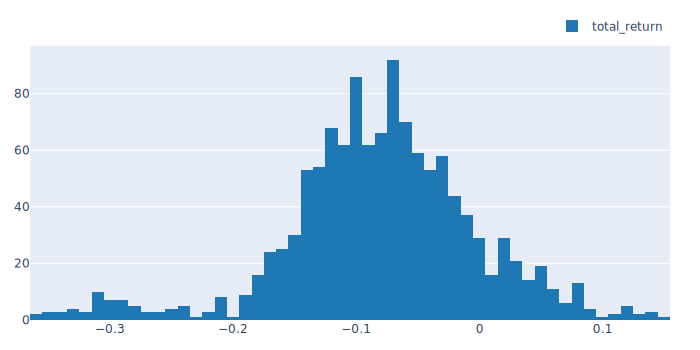

In [55]:
print(vbt_pf_mult.total_return().sort_values())

vbt_pf_mult.total_return().vbt.histplot().show_svg()

In [56]:
# How fast is vbt?
%timeit simulate_mult_from_order_func(periods, uppers, lowers)

4.94 s ± 291 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Even though the strategy is profitable on paper, the majority of hyperparameter combinations yield a loss, so finding a proper "slice" of hyperparameters is just a question of luck when relying on a single backtest. Thanks to vectorbt, we can do thousands of tests in seconds to validate our strategy - the same would last hours using conventional libraries.